In [26]:
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
import warnings

In [27]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
warnings.filterwarnings('ignore')

1\. From the Howell1 dataset, consider only the people younger than 13years old. Estimate the causal association between age and weight. Assume that age influences weight through two paths. First, age influences height, and height influences weight. Second, age directly influences weight through age- related changes in muscle growth and body proportions.

Draw the DAG that represents these causal relationships. And then write a generative simulation that takes age as an input and simulates height and weight, obeying the relationships in the DAG.

In [28]:
d = pd.read_csv("../../Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [29]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


In [30]:
d2 = d[d.age <= 13]

In [31]:
az.summary(d2.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
height,100.829,22.034,62.230,129.540
weight,15.389,6.119,6.662,24.777
age,5.934,4.169,0.000,12.000
male,0.490,0.502,0.000,1.000


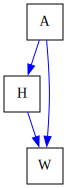

In [32]:
G = nx.DiGraph([("A", "H"), ("A", "W"), ("H", "W")])
draw(G, node_shapes="o")

In [33]:
def sim_HW(A, bAH=5, bHW=0.5, bAW=0.1):
    N = len(A)
    H = np.random.normal(bAH*A, 2, N)
    W = np.random.normal(bHW*H+bAW*A, 2)
    return(pd.DataFrame({"A": A, "H": H, "W": W}))

In [34]:
dat = sim_HW(d2.age)

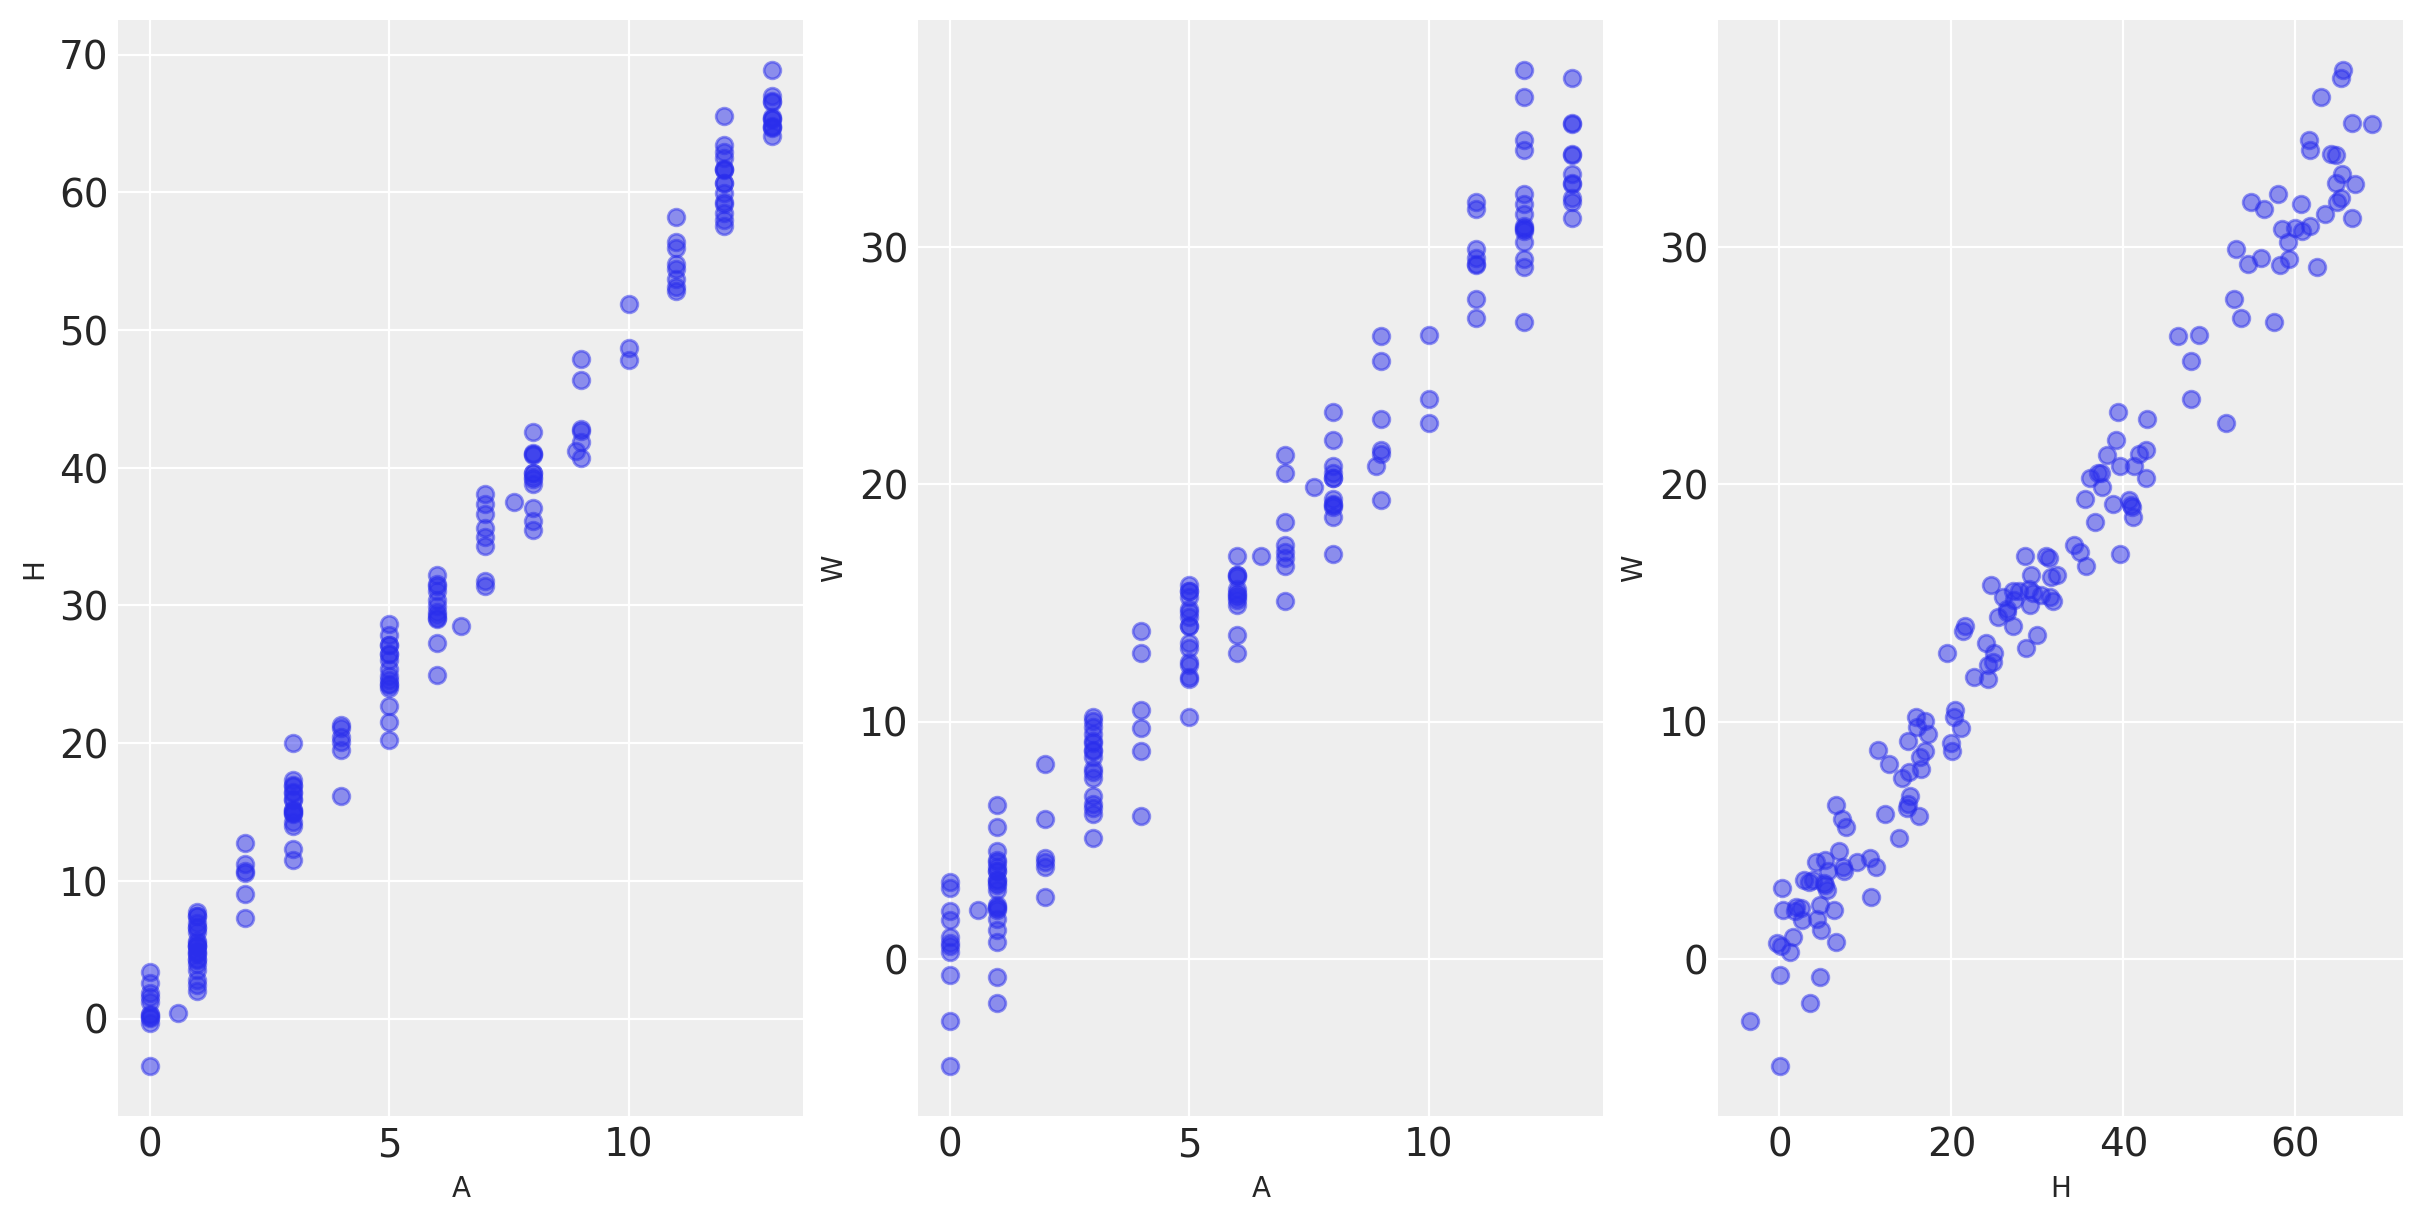

In [35]:
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))
ax0.plot(dat.A, dat.H, "o", alpha=0.5)
ax0.set_xlabel("A")
ax0.set_ylabel("H")
ax1.plot(dat.A, dat.W, "o", alpha=0.5)
ax1.set_xlabel("A")
ax1.set_ylabel("W");
ax2.plot(dat.H, dat.W, "o", alpha=0.5)
ax2.set_xlabel("H")
ax2.set_ylabel("W");

2\. Use a linear regression to estimate the total causal effect of each year of growth on weight.

In [36]:
W = d2.weight.values
A = d2.age.values

with pm.Model() as m:
    b = pm.Uniform("b", 0, 10)
    a = pm.Normal("a", mu=5.0, sigma=1.0)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a + b*A
    W = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)

In [37]:
with m:
    t = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

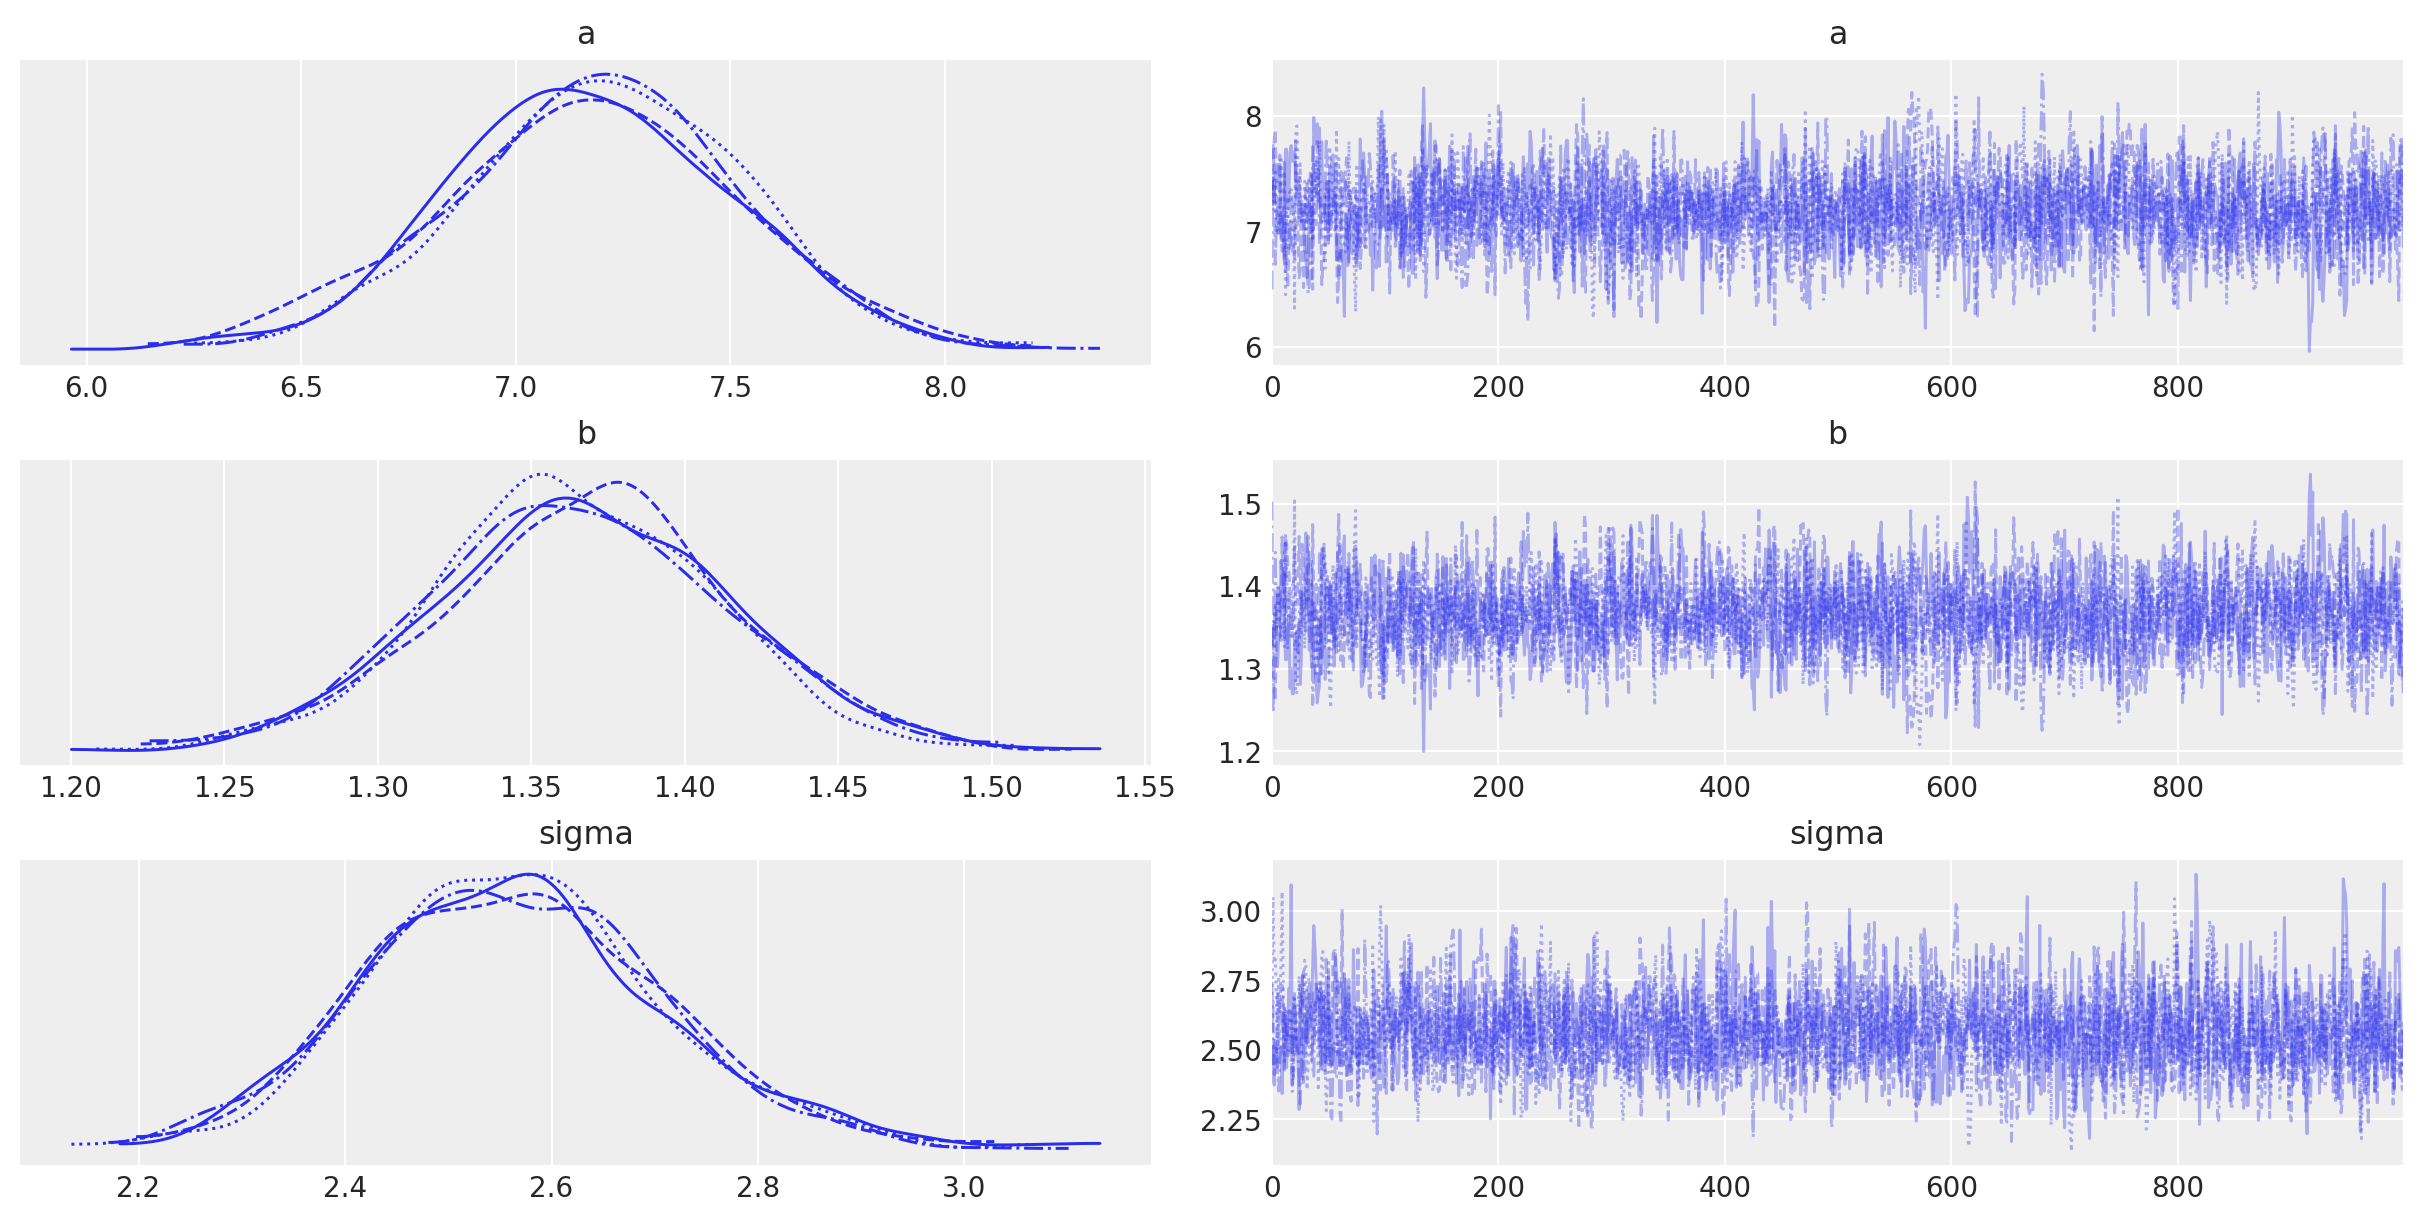

In [38]:
az.plot_trace(t)

In [ ]:
az.summary(t, round_to=2, kind="stats")

3\. Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical variable for sex, to estimate the total causal effect of age on weight separately for boys and girls. How do girls and boys differ? Provide one or more pos- terior contrasts as a summary.

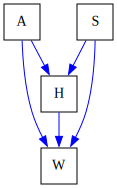

In [ ]:
G = nx.DiGraph([("A", "H"), ("A", "W"), ("H", "W"), ("S", "H"), ("S", "W")])
draw(G, node_shapes="o")

In [41]:
S = d2.male.values
W = d2.weight.values
A = d2.age.values

with pm.Model() as m:
    b = pm.Uniform("b", 0, 10, shape=2)
    a = pm.Normal("a", mu=5.0, sigma=1.0, shape=2)
    sigma = pm.Exponential("sigma", 1.0)
    mu =  a[S] + b[S]*A
    w = pm.Normal("weight", mu=mu, sigma=sigma, observed=W)
    diff_w = pm.Deterministic("diff", mu[0] - mu[1])

In [42]:
with m:
    t = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [43]:
az.plot_trace(t)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'diff'}>,
        <Axes: title={'center': 'diff'}>]], dtype=object)

In [ ]:
az.summary(t, round_to=2, kind="stats")

In [ ]:
t_n = az.extract(t)
num_samples = t_n.sizes["sample"]
t_prime = t_n.isel(sample=range(0, num_samples, 10))
num_samples_t_prime = t_prime.sizes["sample"]
a_seq = np.arange(0, 13)

mu_pred = np.zeros((2, (len(a_seq)), num_samples_t_prime))
for s in range(0, 2):
    for i, a in enumerate(a_seq):
        mu_pred[s][i] = t_prime["a"][s] + t_prime["b"][s]*a

In [ ]:
mu_f = [x.mean() for x in mu_pred[0]]
mu_m = [x.mean() for x in mu_pred[1]]

In [ ]:
_, ax = plt.subplots()
ax.set_xlim(0, 12)
ax.set_ylim(0, 30)
ax.scatter(A, W, marker="o", alpha=0.1, c=S)
ax.set_xlabel("A")
ax.set_ylabel("W")

for a, b in zip(a_seq, mu_f):
    ax.scatter(a, b, marker="x", alpha=0.9, c="#ff0000")

for a, b in zip(a_seq, mu_m):
    ax.scatter(a, b, marker="+", alpha=0.9, c="#00ff00")

az.plot_hdi(a_seq, np.transpose(mu_pred[0]), color="red");
az.plot_hdi(a_seq, np.transpose(mu_pred[1]), color="blue");

In [48]:
contrasts = np.empty((400, 13), dtype=float)
for a in a_seq:
    w_f = np.random.normal(6.69 + 1.33*a, 2.48, 400)
    w_m = np.random.normal(7.25 + 1.44*a, 2.48, 400)
    for j in range(0, 400):
        contrasts[j, a] = w_m[j] - w_f[j]

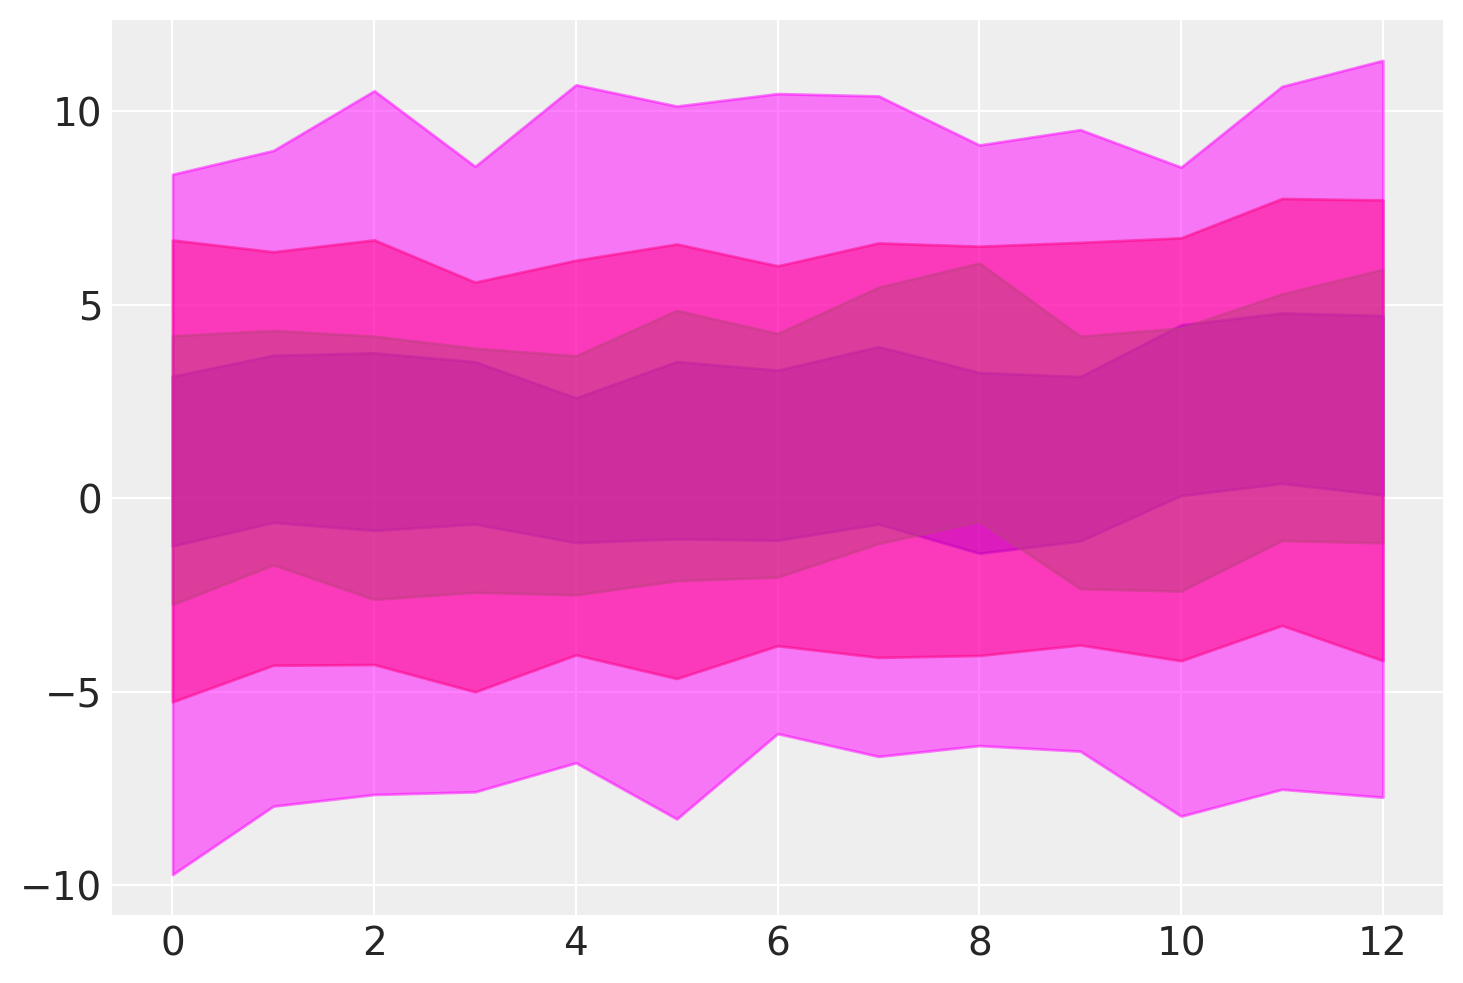

In [49]:
intervals = [0.5, 0.67, 0.89, 0.99]
colors = ["#0000FF", "#00FF00", "#FF0000", "#FF00FF"]

for e in zip(intervals, colors):
    az.plot_hdi(a_seq, contrasts, hdi_prob=e[0], color=e[1], smooth=False)